# Pre-Requisites

Load neccesary packages/libraries and print versions for reference.

Reference: Python 3.12.7 - miniconda3

In [2]:
# Packages and Libraries
import cellxgene_census
import tiledbsoma
import spatialdata as sd
import spatialdata_plot

import warnings
warnings.filterwarnings("ignore")

# Versions of required libraries
print("cellxgene_census",cellxgene_census.__version__)
print("tiledbsoma", tiledbsoma.__version__)
print("spatialdata", sd.__version__)
print("spatialdata plot", spatialdata_plot.__version__)

/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


cellxgene_census 1.16.2
tiledbsoma 1.15.6
spatialdata 0.3.0
spatialdata plot 0.2.9


# Query CellxGene for 'dataset_id'

> UNFINISHED
- Filter for datasets I actually want


In [17]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    #Print Census level metadata
    print("Census level metadata\n")
    print(list(census["census_info"].keys()))

    print("\n")

    print("Census datasets info\n")
    print(census["census_info"]["datasets"].read().concat().to_pandas().head().to_string())

Census level metadata

['datasets', 'organisms', 'summary', 'summary_cell_counts']


Census datasets info

   soma_joinid                                                                                                                                                                                                                                                                                                        citation                         collection_id                                                                                                            collection_name              collection_doi              collection_doi_label                            dataset_id                    dataset_version_id                                     dataset_title                          dataset_h5ad_path  dataset_total_cell_count
0            0  Publication: https://doi.org/10.1016/j.isci.2022.104097 Dataset Version: https://datasets.cellxgene.cziscience.com/f76861bb-becb-4eb7-82fc-7

In [22]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    cell_metadata = census["census_spatial_sequencing"]["homo_sapiens"].obs.read(
        value_filter = "tissue == 'labial gland' and disease == 'Sjogren syndrome'",
        column_names = ["assay", "tissue", "tissue_general", "disease", "dataset_id"]
    )
    
    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

    print(cell_metadata)

# Prints all the unique dataset_ids
print(cell_metadata['dataset_id'].unique())

                                assay        tissue  tissue_general  \
0      Visium Spatial Gene Expression  labial gland  exocrine gland   
1      Visium Spatial Gene Expression  labial gland  exocrine gland   
2      Visium Spatial Gene Expression  labial gland  exocrine gland   
3      Visium Spatial Gene Expression  labial gland  exocrine gland   
4      Visium Spatial Gene Expression  labial gland  exocrine gland   
...                               ...           ...             ...   
50018  Visium Spatial Gene Expression  labial gland  exocrine gland   
50019  Visium Spatial Gene Expression  labial gland  exocrine gland   
50020  Visium Spatial Gene Expression  labial gland  exocrine gland   
50021  Visium Spatial Gene Expression  labial gland  exocrine gland   
50022  Visium Spatial Gene Expression  labial gland  exocrine gland   

                disease                            dataset_id  
0      Sjogren syndrome  00ba8341-48ec-4e4e-bb56-be0dd2dd7913  
1      Sjogren synd

# Spatial Data Export

Query the human experiment in census enabling visualization and analysis.

Perform the query using tiledbsoma instead of cellxgene_census

> Change 'dataset_id' --- Otherwise working

In [23]:
# Export to spatial data

census = cellxgene_census.open_soma(census_version="2025-01-30")

exp = census["census_spatial_sequencing"]["homo_sapiens"]

#tiledbsoma export query

with exp.axis_query(
    measurement_name="RNA",
    obs_query=tiledbsoma.AxisQuery(value_filter="dataset_id == '00ba8341-48ec-4e4e-bb56-be0dd2dd7913'") # query specific dataset instead of by obs metadata
) as query:
    sdata = query.to_spatialdata(X_name="raw")

sdata

SpatialData object
├── Images
│     └── '00ba8341-48ec-4e4e-bb56-be0dd2dd7913_3b_a': DataArray[cyx] (3, 1978, 2000)
├── Shapes
│     └── '00ba8341-48ec-4e4e-bb56-be0dd2dd7913_loc': GeoDataFrame shape: (4992, 3) (2D shapes)
└── Tables
      └── 'RNA': AnnData (4992, 44405)
with coordinate systems:
    ▸ '00ba8341-48ec-4e4e-bb56-be0dd2dd7913', with elements:
        00ba8341-48ec-4e4e-bb56-be0dd2dd7913_3b_a (Images), 00ba8341-48ec-4e4e-bb56-be0dd2dd7913_loc (Shapes)

INFO     Rasterizing image for faster rendering.                                                                   


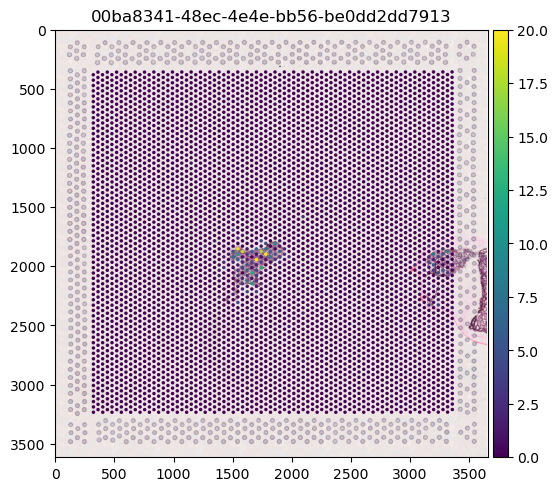

In [24]:
sdata.tables

sdata["RNA"].var.head()

#set index of var dataframe for the expression data
sdata.tables["RNA"].var.set_index("feature_name", inplace=True)

sdata["RNA"].var.head()

(
    sdata.pl.render_images()
    .pl.render_shapes(color="MALAT1")
    .pl.show()
)